In [1]:
# notebooks use their location as their working directory, so
# if we are in a subfolder, move to the main folder.  
# This however can safely be run multiple times
#setwd("M:/lecospec/lecospec")
if(!dir.exists("Functions/")){
    setwd("../")
    if(!dir.exists("Functions")){
        setwd("M:/lecospec/lecospec/")
    }
}
source("Functions/lecospectR.R", echo = FALSE)
library(class)
library(caret)
library(vegan)

Loading required package: tidyverse

Warning message:
"package 'tidyverse' was built under R version 4.2.2"
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
Warning message:
"package 'ggplot2' was built under R version 4.2.2"
Warning message:
"package 'tibble' was built under R version 4.2.2"
Warning message:
"package 'tidyr' was built under R version 4.2.2"
Warning message:
"package 'readr' was built under R version 4.2.2"
Warning message:
"package 'purrr' was built under R version 4.2.2"
Warning message:
"package 'dplyr' was built under R version 4.2.2"
Warning message:
"package 'stringr' was built under R version 4.2.2"
Warning message:
"package 'forcats' was built under R version 4.2.2"
── Conflicts ───────────────────────────────────────────────────────────────

## Load the Data

In [2]:
# spectral library
base_path <- "./Output/C_001_SC3_Cleaned_SpectralLib.csv"
veg_index_path <- "./Data/D_002_SpecLib_Derivs.csv"
speclib <- read.csv(base_path)
veg_indices <- read.csv(veg_index_path)

In [3]:
# Targets 
targets <- veg_indices[!is.na(veg_indices$Functional_group1),"Functional_group1"] %>% as.factor()
# weights
weights_by_pft <- targets_to_weights(targets)

In [4]:
# image-based validation
uav_speclib_df <- read.csv(
    "Data/Ground_Validation/PFT_image_spectra/PFT_Image_SpectralLib_Clean_unsmoothed.csv", 
    header = TRUE)
image_validation <- uav_speclib_df[,16:(ncol(uav_speclib_df) - 1)]
validation_labels <- uav_speclib_df$FncGrp1 %>% as.factor()
#levels(validation_labels) <- c(levels(validation_labels), "Forb") 



## Base transformation
This removes infinity, outliers and NAs from the data.  

[1] "Imputing..."
[1] "Imputing..."


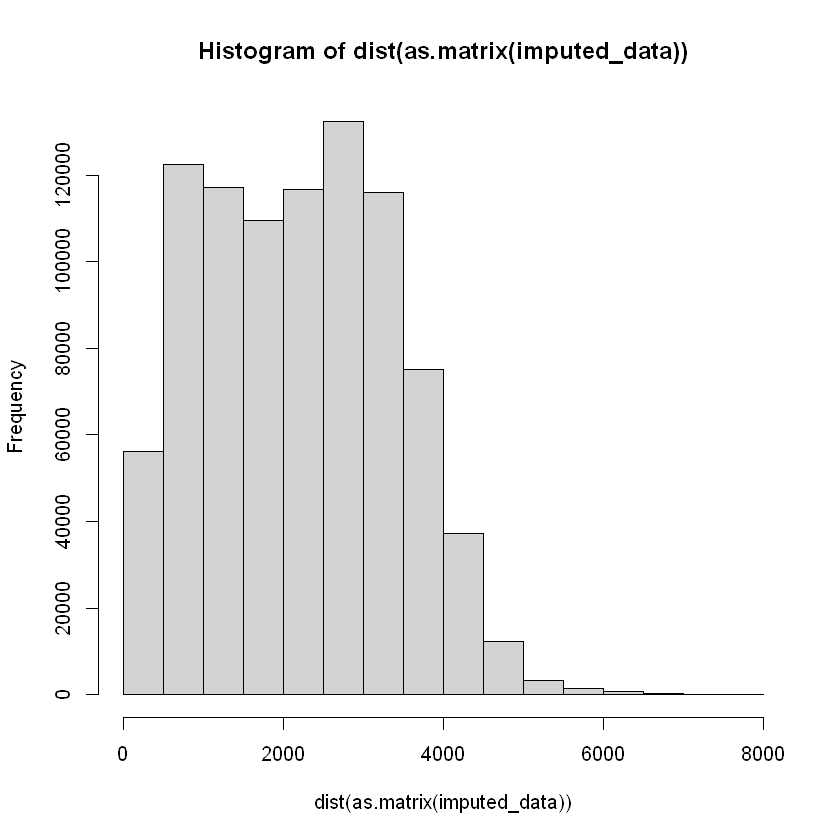

In [5]:
numeric_data <- veg_indices[!is.na(veg_indices$Functional_group1),35:(ncol(veg_indices)-1)]
numeric_data <- inf_to_na(numeric_data)
imputed_data_1 <- impute_spectra(numeric_data)
imputed_data_no_outliers <- outliers_to_na(imputed_data_1)
imputed_data <- impute_spectra(imputed_data_no_outliers)
outlier_indices <- detect_outliers_columnwise(imputed_data[,1:95])
filtered_data <- imputed_data[!outlier_indices,]
hist(dist(as.matrix(imputed_data)))
min_max_scaled_data <- columnwise_min_max_scale(imputed_data)

In [6]:
print(colnames(imputed_data))

  [1] "Boochs"       "Boochs2"      "CARI"         "Carter"       "Carter2"     
  [6] "Carter3"      "Carter4"      "Carter5"      "Carter6"      "CI"          
 [11] "CI2"          "ClAInt"       "CRI1"         "CRI2"         "CRI3"        
 [16] "CRI4"         "D1"           "D2"           "Datt"         "Datt2"       
 [21] "Datt3"        "Datt4"        "Datt5"        "Datt6"        "DD"          
 [26] "DDn"          "DPI"          "DWSI4"        "EGFN"         "EGFR"        
 [31] "EVI"          "GDVI2"        "GDVI3"        "GDVI4"        "GI"          
 [36] "Gitelson"     "Gitelson2"    "GMI1"         "GMI2"         "GreenNDVI"   
 [41] "Maccioni"     "MCARI"        "MCARIOSAVI"   "MCARI2"       "MCARI2OSAVI2"
 [46] "mND705"       "mNDVI"        "MPRI"         "MSAVI"        "mSR"         
 [51] "mSR2"         "mSR705"       "MTCI"         "MTVI"         "NDVI"        
 [56] "NDVI2"        "NDVI3"        "NPCI"         "OSAVI"        "OSAVI2"      
 [61] "PARS"         "PRI"  

## Transform the Image-based Data

In [7]:
veg_index_names <- read.csv("assets/vegIndicesUsed.csv")$x
validation_indices <- get_vegetation_indices(image_validation, NULL)
# drop NAs

validation_indices <- inf_to_na(validation_indices)
validation_indices <- impute_spectra(validation_indices)
validation_indices <- outliers_to_na(validation_indices)
validation_indices <- impute_spectra(validation_indices)


min_max_scaled_validation <- columnwise_min_max_scale(validation_indices)

#hist(as.matrix(min_max_scaled_validation))

[1] "Imputing..."
[1] "Imputing..."


In [8]:
validation_bands <- resample_df(image_validation,normalize = FALSE)

Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



In [9]:
print(colnames(validation_bands))

  [1] "X397.593"     "X399.444"     "X401.296"     "X403.148"     "X405"        
  [6] "X406.851"     "X408.703"     "X410.555"     "X412.407"     "X414.258"    
 [11] "X416.11"      "X417.962"     "X419.814"     "X421.666"     "X423.517"    
 [16] "X425.369"     "X427.221"     "X429.073"     "X430.924"     "X432.776"    
 [21] "X434.628"     "X436.48"      "X438.332"     "X440.183"     "X442.035"    
 [26] "X443.887"     "X445.739"     "X447.59"      "X449.442"     "X451.294"    
 [31] "X453.146"     "X454.998"     "X456.849"     "X458.701"     "X460.553"    
 [36] "X462.405"     "X464.256"     "X466.108"     "X467.96"      "X469.812"    
 [41] "X471.664"     "X473.515"     "X475.367"     "X477.219"     "X479.071"    
 [46] "X480.922"     "X482.774"     "X484.626"     "X486.478"     "X488.33"     
 [51] "X490.181"     "X492.033"     "X493.885"     "X495.737"     "X497.588"    
 [56] "X499.44"      "X501.292"     "X503.144"     "X504.996"     "X506.847"    
 [61] "X508.699"     "X510.5

In [10]:
image_weights <- targets_to_weights(validation_labels %>% as.factor())

## PCA 
This is where we calcuate PCA for the ground and image spectra

Importance of components:
                            PC1       PC2       PC3       PC4      PC5      PC6
Standard deviation     3303.219 1335.3276 346.49583 182.31505 39.04198 27.94348
Proportion of Variance    0.849    0.1388   0.00934   0.00259  0.00012  0.00006
Cumulative Proportion     0.849    0.9878   0.99714   0.99973  0.99985  0.99991
                            PC7      PC8      PC9 PC10  PC11  PC12  PC13  PC14
Standard deviation     21.86838 17.50744 10.27381 7.97 6.305 6.109 5.902 4.692
Proportion of Variance  0.00004  0.00002  0.00001 0.00 0.000 0.000 0.000 0.000
Cumulative Proportion   0.99994  0.99997  0.99998 1.00 1.000 1.000 1.000 1.000
                        PC15 PC16  PC17  PC18 PC19  PC20  PC21  PC22 PC23  PC24
Standard deviation     4.462 4.18 3.829 3.232 2.84 2.677 2.293 2.074  1.8 1.753
Proportion of Variance 0.000 0.00 0.000 0.000 0.00 0.000 0.000 0.000  0.0 0.000
Cumulative Proportion  1.000 1.00 1.000 1.000 1.00 1.000 1.000 1.000  1.0 1.000
                  

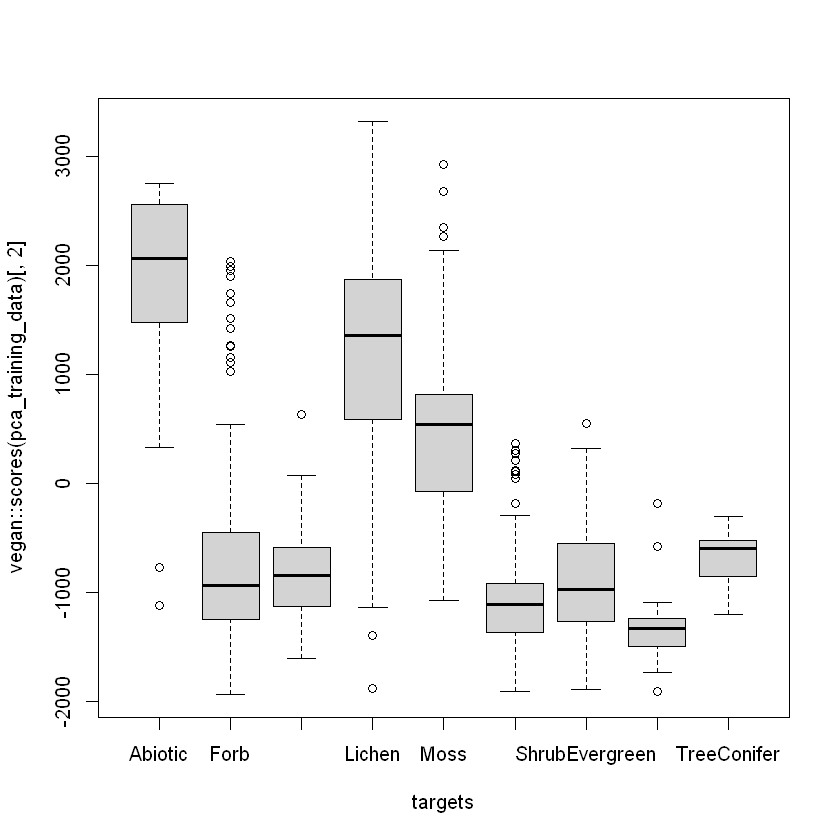

In [11]:
# fit a PCA to the ground spectra
pca_fit <- stats::prcomp(imputed_data[,1:(ncol(numeric_data) - 66)], center = FALSE, scale. = FALSE)
print(summary(pca_fit))
pca_training_data <- predict(pca_fit, imputed_data[,1:(ncol(numeric_data) - 66)])[,1:64]
boxplot(vegan::scores(pca_training_data)[,2]~targets)

## Standardization
This cell standardizes the input to center at zero with standard deviation one.

In [12]:
# standardization
indice_standardizer <- caret::preProcess(imputed_data[,1:95])
standardized_indices <- predict(indice_standardizer, imputed_data[,1:95])

val_standardizer <- caret::preProcess(validation_indices)
standardized_validation <- predict(val_standardizer, validation_indices)

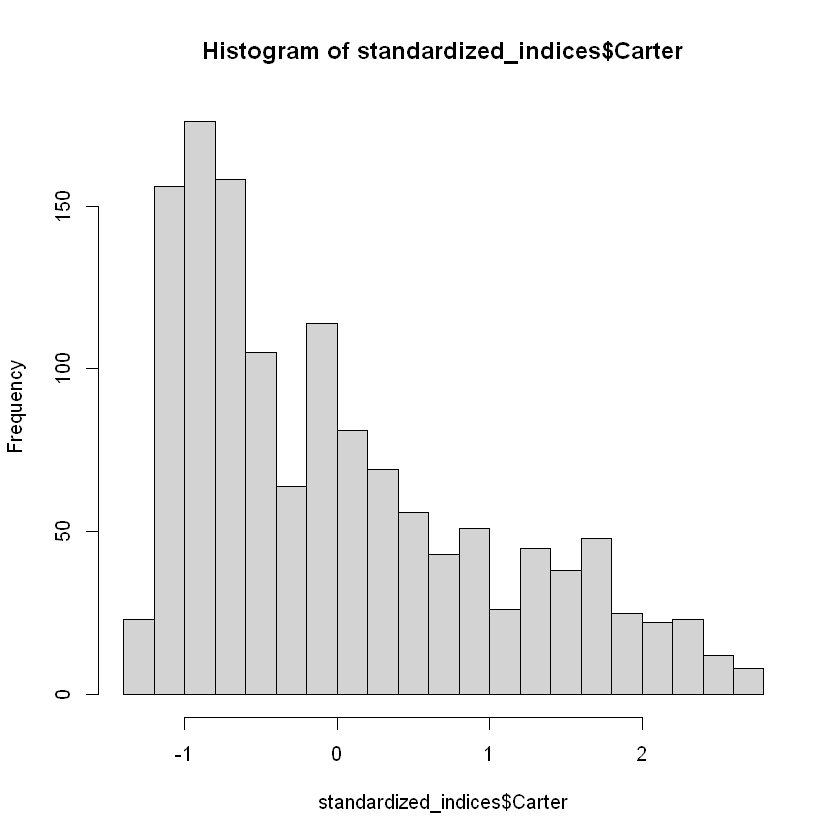

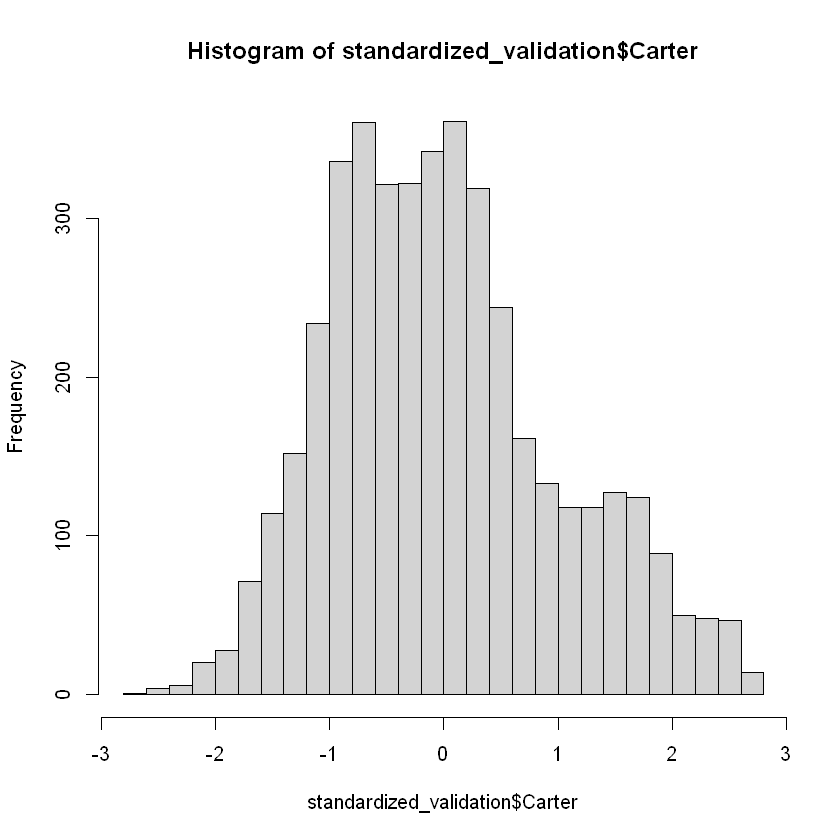

In [13]:
hist(standardized_indices$Carter, breaks = 20)
hist(standardized_validation$Carter, breaks = 20)

## Min-Max Scaling
This executes the min-man scalaing (to make the data on the scale [0,1])

In [14]:
# plots
#hist(min_max_scaled_validation %>% as.matrix())
#hist(min_max_scaled_data %>% as.matrix())
print(colnames(validation_indices))
print(str(pca_fit))
#pca_validation_data <- predict(pca_fit, validation_indices)[,1:64] %>% as.data.frame()
#boxplot(vegan::scores(pca_validation_data)[,2]~validation_labels)

 [1] "Boochs"       "Boochs2"      "CARI"         "Carter"       "Carter2"     
 [6] "Carter3"      "Carter4"      "Carter5"      "Carter6"      "CI"          
[11] "CI2"          "ClAInt"       "CRI1"         "CRI2"         "CRI3"        
[16] "CRI4"         "D1"           "D2"           "Datt"         "Datt2"       
[21] "Datt3"        "Datt4"        "Datt5"        "Datt6"        "DD"          
[26] "DDn"          "DPI"          "DWSI4"        "EGFN"         "EGFR"        
[31] "EVI"          "GDVI2"        "GDVI3"        "GDVI4"        "GI"          
[36] "Gitelson"     "Gitelson2"    "GMI1"         "GMI2"         "GreenNDVI"   
[41] "Maccioni"     "MCARI"        "MCARIOSAVI"   "MCARI2"       "MCARI2OSAVI2"
[46] "mND705"       "mNDVI"        "MPRI"         "MSAVI"        "mSR"         
[51] "mSR2"         "mSR705"       "MTCI"         "MTVI"         "NDVI"        
[56] "NDVI2"        "NDVI3"        "NPCI"         "OSAVI"        "OSAVI2"      
[61] "PARS"         "PRI"          "PRIC

## KS Tests of Transferrability
These next few cells test whether the veg indices are similarly distributed (i.e. could be samples drawn from the same distribution)

The hypothesis is that columns (veg indices) that pass this test can safely be used across models and conditions (are transferrable)

In [15]:
source("Functions/lecospectR.R")
ks_test_results <- test_transferrability(min_max_scaled_data, min_max_scaled_validation)
print(ks_test_results)

Warning message in ks.test.default(df1[, col], df2[, col]):
"p-value will be approximate in the presence of ties"
Warning message in ks.test.default(df1[, col], df2[, col]):
"p-value will be approximate in the presence of ties"
Warning message in ks.test.default(df1[, col], df2[, col]):
"p-value will be approximate in the presence of ties"
Warning message in ks.test.default(df1[, col], df2[, col]):
"p-value will be approximate in the presence of ties"
Warning message in ks.test.default(df1[, col], df2[, col]):
"p-value will be approximate in the presence of ties"
Warning message in ks.test.default(df1[, col], df2[, col]):
"p-value will be approximate in the presence of ties"
Warning message in ks.test.default(df1[, col], df2[, col]):
"p-value will be approximate in the presence of ties"
Warning message in ks.test.default(df1[, col], df2[, col]):
"p-value will be approximate in the presence of ties"
Warning message in ks.test.default(df1[, col], df2[, col]):
"p-value will be approximate

$Boochs

	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df1[, col] and df2[, col]
D = 0.19513, p-value < 2.2e-16
alternative hypothesis: two-sided


$Boochs2

	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df1[, col] and df2[, col]
D = 0.35689, p-value < 2.2e-16
alternative hypothesis: two-sided


$CARI

	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df1[, col] and df2[, col]
D = 0.13392, p-value = 2.22e-16
alternative hypothesis: two-sided


$Carter

	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df1[, col] and df2[, col]
D = 0.42267, p-value < 2.2e-16
alternative hypothesis: two-sided


$Carter2

	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df1[, col] and df2[, col]
D = 0.35641, p-value < 2.2e-16
alternative hypothesis: two-sided


$Carter3

	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df1[, col] and df2[, col]
D = 0.38668, p-value < 2.2e-16
alternative hypothesis: two-sided


$Carter4

	Asymptotic two-sample Kolmogorov-Smirnov test

## t-SNE
Examine the clusters in the data via *t*-SNE

Warning message:
"package 'Rtsne' was built under R version 4.2.2"


 [1] "N"                   "Y"                   "costs"              
 [4] "itercosts"           "origD"               "perplexity"         
 [7] "theta"               "max_iter"            "stop_lying_iter"    
[10] "mom_switch_iter"     "momentum"            "final_momentum"     
[13] "eta"                 "exaggeration_factor"


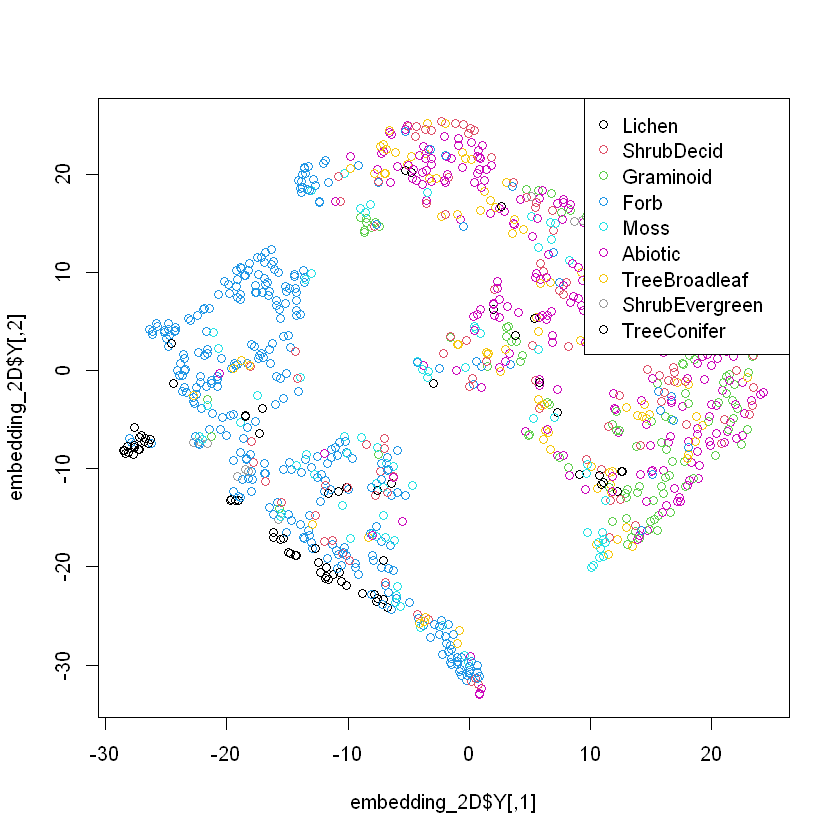

In [16]:
library(Rtsne)
unique_indices <- imputed_data[!duplicated(imputed_data),1:95]
normalized_veg_indices <- Rtsne::normalize_input(
    unique_indices %>% 
    as.matrix()
    )
embedding_2D <- Rtsne::Rtsne(normalized_veg_indices)
print(names(embedding_2D))

plot(embedding_2D$Y, col = as.factor(targets))
par(xpd=T)
legend("topright", legend = unique(targets), col = seq_along(unique(targets)),pch = 1)

## Vector Quantization Classifier
This fits a LVQ classifier to the data and then 

In [17]:
print(length(validation_labels))
print(nrow(min_max_scaled_validation))

[1] 4264
[1] 4264


## Train-Test Split

Perform an 80-20 split on the data (use the split on the fly during the grid search)

In [18]:
grd_train_idx <- caTools::sample.split(targets, SplitRatio = 0.8)

In [19]:
img_train_idx <- caTools::sample.split(validation_labels, SplitRatio = 0.8)

## Random Forest
trains a random forest model

In [20]:

rf_model <- ranger::ranger(
    num.trees = 256,
    case.weights = image_weights,
    importance = "impurity",
    classification = TRUE,
    x = validation_indices,
    y = validation_labels
)

print(rf_model)

Ranger result

Call:
 ranger::ranger(num.trees = 256, case.weights = image_weights,      importance = "impurity", classification = TRUE, x = validation_indices,      y = validation_labels) 

Type:                             Classification 
Number of trees:                  256 
Sample size:                      4264 
Number of independent variables:  95 
Mtry:                             9 
Target node size:                 1 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error:             3.81 % 


In [21]:
predictions <- predict(rf_model, validation_indices)$predictions %>% 
    as.factor()
confusion_matrix <- caret::confusionMatrix(
    predictions, 
    validation_labels, 
    mode = "everything")
print(confusion_matrix)

Confusion Matrix and Statistics

                Reference
Prediction       Abiotic Graminoid Lichen Moss ShrubDecid ShrubEvergreen
  Abiotic            820         0      0    0          0              0
  Graminoid            0       145      0    0          0              0
  Lichen               0         0    155    0          0              0
  Moss                 0         0      0   31          0              0
  ShrubDecid           0         0      0    0        129              0
  ShrubEvergreen       0         0      0    0          0            222
  TreeBroadleaf        0         0      0    0          0              0
  TreeConifer          0         0      0    0          0              0
                Reference
Prediction       TreeBroadleaf TreeConifer
  Abiotic                    0           0
  Graminoid                  0          12
  Lichen                     0           0
  Moss                       0           0
  ShrubDecid                 0           0


In [22]:
save(rf_model, file="mle/models/gs/rf_base_2.rda")

In [23]:
important_variables <- sort(rf_model$variable.importance, decreasing = TRUE)
print(important_variables)

         SR2         PSND       mND705       mSR705    GreenNDVI          SR7 
  128.520317   104.774256   100.032521    93.767763    85.305137    76.742044 
       NDVI2         PARS           SR         GMI2         mSR2         SPVI 
   75.429614    74.702792    65.990277    65.843327    65.781007    65.175882 
    Maccioni       ClAInt         CRI2       OSAVI2 MCARI2OSAVI2          SR1 
   63.768975    61.448096    61.217422    58.398671    57.970162    57.454888 
         SR8          CI2       MCARI2         MTCI    Vogelmann         SRPI 
   56.841886    55.726153    55.572488    54.964454    54.695669    54.692910 
         SR3         GMI1         PSSR    Gitelson2      Carter6          EVI 
   54.580810    53.709701    52.840082    52.739113    52.734428    52.585196 
         TVI        DWSI4        NDVI3     Gitelson         Datt TCARI2OSAVI2 
   52.371087    50.411416    50.356453    50.004914    49.828788    49.623388 
      Carter         MTVI        Datt5      Carter3 

In [24]:
important_variable_names<- names(important_variables)
print(important_variable_names)

 [1] "SR2"          "PSND"         "mND705"       "mSR705"       "GreenNDVI"   
 [6] "SR7"          "NDVI2"        "PARS"         "SR"           "GMI2"        
[11] "mSR2"         "SPVI"         "Maccioni"     "ClAInt"       "CRI2"        
[16] "OSAVI2"       "MCARI2OSAVI2" "SR1"          "SR8"          "CI2"         
[21] "MCARI2"       "MTCI"         "Vogelmann"    "SRPI"         "SR3"         
[26] "GMI1"         "PSSR"         "Gitelson2"    "Carter6"      "EVI"         
[31] "TVI"          "DWSI4"        "NDVI3"        "Gitelson"     "Datt"        
[36] "TCARI2OSAVI2" "Carter"       "MTVI"         "Datt5"        "Carter3"     
[41] "NPCI"         "Carter2"      "SR6"          "SumDr2"       "Datt6"       
[46] "OSAVI"        "TCARI2"       "MPRI"         "MSAVI"        "RDVI"        
[51] "NDVI"         "SAVI"         "CRI1"         "DDn"          "TGI"         
[56] "CRI3"         "Vogelmann2"   "GDVI4"        "GI"           "CRI4"        
[61] "SR5"          "Vogelmann4"   "GDVI

In [25]:
# generate the test data
set.seed(61718L)
permutation <- permute::shuffle(validation_labels)
val_t_chars <- validation_labels[permutation] %>% as.character()
print(val_t_chars[1:5])
counts <- c(0,0,0,0,0,0,0,0,0)
samples <- vector(mode = "logical", length=length(validation_labels))

for(i in seq_along(val_t_chars)){
    samples[[i]] <- FALSE
    if(val_t_chars[[i]] == "Abiotic"){
        if(counts[[1]]<31){
            samples[[i]] <-  TRUE
            counts[[1]] <- counts[[1]] + 1
        }

    } else if (val_t_chars[[i]] == "Graminoid"){
        if(counts[[2]] < 31){
            samples[[i]] <-  TRUE
            counts[[2]] <- counts[[2]] + 1
        }
    } else if (val_t_chars[[i]] == "Forb"){
        if(counts[[3]] < 31){
            samples[[i]] <-  TRUE
            counts[[3]] <- counts[[3]] + 1
        }
    } else if (val_t_chars[[i]] == "Lichen"){
        if(counts[[4]] < 31){
            samples[[i]] <-  TRUE
            counts[[4]] <- counts[[4]] + 1
        }
    } else if (val_t_chars[[i]] == "Moss"){
        if(counts[[5]] < 31){
            samples[[i]] <-  TRUE
            counts[[5]] <- counts[[5]] + 1
        }
    } else if (val_t_chars[[i]] == "ShrubDecid"){
        if(counts[[6]] < 31){
            samples[[i]] <-  TRUE
            counts[[6]] <- counts[[6]] + 1
        }
    } else if (val_t_chars[[i]] == "ShrubEvergreen"){
        if(counts[[7]] < 31){
            samples[[i]] <-  TRUE
            counts[[7]] <- counts[[7]] + 1
        }
    } else if (val_t_chars[[i]] == "TreeConifer"){
        if(counts[[8]] < 31){
            samples[[i]] <-  TRUE
            counts[[8]] <- counts[[8]] + 1
        }
    } else if (val_t_chars[[i]] == "TreeBroadleaf"){
        if(counts[[9]] < 31){
            samples[[i]] <-  TRUE
            counts[[9]] <- counts[[9]] + 1
        }
    }
}


temp <- validation_labels[permutation] %>% as.factor()
test_labels <- temp[as.vector(samples)]
temp <- validation_indices[permutation,] %>% as.data.frame()
test_data <- temp[as.vector(samples),]



[1] "Lichen"         "TreeConifer"    "TreeConifer"    "ShrubEvergreen"
[5] "TreeConifer"   


In [26]:
print(test_labels %>% table())

.
       Abiotic      Graminoid         Lichen           Moss     ShrubDecid 
            31             31             31             31             31 
ShrubEvergreen  TreeBroadleaf    TreeConifer 
            31             31             31 


# Grid Search

This next section defines all the essentials for the grid search across our different candidate models. 

## Candidates

### Models
* Random Forest
* Learned Vector Quantization (LVQ)
* k-Nearest Neighbor (kNN)

Could also consider Support Vector Machine (SVM), Gradient Boosted Trees (e.g. LightGBM, XGBoost), matched filtering, Logistic Regression, etc.

### Data/Transformations

For each of the image/training data sets, test the following:
* raw, 
* raw (no outliers)
* standardized (z-score standardization)
* standardized (z-score standardization, no outliers)
* min-max scaled
* min-max scaled (no outliers)
* PCA
* PCA no outliers

Need to also vary how many columns are included in the analysis

In [27]:
print(dim(imputed_data))
print(dim(standardized_indices))
print(dim(min_max_scaled_data))
print(dim(validation_indices))
print(dim(standardized_validation))
print(dim(min_max_scaled_validation))


[1] 1343  214
[1] 1343   95
[1] 1343  214
[1] 4264   95
[1] 4264   95
[1] 4264   95


In [28]:
print(colnames(imputed_data))

  [1] "Boochs"       "Boochs2"      "CARI"         "Carter"       "Carter2"     
  [6] "Carter3"      "Carter4"      "Carter5"      "Carter6"      "CI"          
 [11] "CI2"          "ClAInt"       "CRI1"         "CRI2"         "CRI3"        
 [16] "CRI4"         "D1"           "D2"           "Datt"         "Datt2"       
 [21] "Datt3"        "Datt4"        "Datt5"        "Datt6"        "DD"          
 [26] "DDn"          "DPI"          "DWSI4"        "EGFN"         "EGFR"        
 [31] "EVI"          "GDVI2"        "GDVI3"        "GDVI4"        "GI"          
 [36] "Gitelson"     "Gitelson2"    "GMI1"         "GMI2"         "GreenNDVI"   
 [41] "Maccioni"     "MCARI"        "MCARIOSAVI"   "MCARI2"       "MCARI2OSAVI2"
 [46] "mND705"       "mNDVI"        "MPRI"         "MSAVI"        "mSR"         
 [51] "mSR2"         "mSR705"       "MTCI"         "MTVI"         "NDVI"        
 [56] "NDVI2"        "NDVI3"        "NPCI"         "OSAVI"        "OSAVI2"      
 [61] "PARS"         "PRI"  

In [29]:
print(colnames(validation_bands))

  [1] "X397.593"     "X399.444"     "X401.296"     "X403.148"     "X405"        
  [6] "X406.851"     "X408.703"     "X410.555"     "X412.407"     "X414.258"    
 [11] "X416.11"      "X417.962"     "X419.814"     "X421.666"     "X423.517"    
 [16] "X425.369"     "X427.221"     "X429.073"     "X430.924"     "X432.776"    
 [21] "X434.628"     "X436.48"      "X438.332"     "X440.183"     "X442.035"    
 [26] "X443.887"     "X445.739"     "X447.59"      "X449.442"     "X451.294"    
 [31] "X453.146"     "X454.998"     "X456.849"     "X458.701"     "X460.553"    
 [36] "X462.405"     "X464.256"     "X466.108"     "X467.96"      "X469.812"    
 [41] "X471.664"     "X473.515"     "X475.367"     "X477.219"     "X479.071"    
 [46] "X480.922"     "X482.774"     "X484.626"     "X486.478"     "X488.33"     
 [51] "X490.181"     "X492.033"     "X493.885"     "X495.737"     "X497.588"    
 [56] "X499.44"      "X501.292"     "X503.144"     "X504.996"     "X506.847"    
 [61] "X508.699"     "X510.5

In [30]:
# define the data sets to loop over
gs_train <- list(
    #pca_training_data,
    imputed_data,
    scale(imputed_data),
    #standardized_indices[,important_variable_names],
    min_max_scaled_data,
    columnwise_robust_scale(imputed_data)
)

gs_test <- list(
    cbind(validation_indices, validation_bands)[permutation,][samples,],
    cbind(standardized_validation, scale(validation_bands))[permutation,][samples,],
    cbind(min_max_scaled_validation, columnwise_min_max_scale(validation_bands))[permutation,][samples,],
    columnwise_robust_scale(
        cbind(validation_indices, validation_bands)[permutation,][samples,]
    )
    #pca_validation_data[permutation,][samples,],
#    min_max_scaled_validation[permutation,][samples,],
 #   standardized_validation[permutation,][samples,]
    #pca_validation_data[-img_train_idx]

)

gs_train_labels <- list(
    targets,
    targets,
    targets,
    targets,
    targets,
    targets
)

gs_samples <- list(
    test_labels,
    test_labels,
    test_labels,
    test_labels,
    test_labels,
    test_labels,
    test_labels
)

In [31]:
gs_methods <- list(
    #"svmLinear",
    #"rmda",
    "RFlda",
    #"adaboost",
    #"xgbLinear",
    #"xgbTree",
    #"xgbDART",
    "svmRadialWeights",
    #"mda",
    "knn",
    #"lda",
    "ranger"
    #"hda"# heteroscedastic discriminant analysis
)
# add: PLS-LDA, kNN, SVM+poly Kernel, SVM+Exp Kernel, more boosting, 

In [32]:
gs_weight_text <- c(
    "prior weights",
    NULL
)

gs_weights <- list(
    weights_by_pft,
    weights_by_pft,
    weights_by_pft,
    weights_by_pft,
    weights_by_pft,
    weights_by_pft,
    weights_by_pft,
    image_weights,
    image_weights,
    image_weights
)

fit_ctrl <- caret::trainControl(
    method = "repeatedcv",
    number = 10,
    repeats = 10,
    #classProbs = TRUE,
    allowParallel = TRUE
)

In [33]:
getwd()

[1] "M:/lecospec/lecospec"

In [34]:
for(i in seq_along(gs_train)){
    df <- data.frame(gs_train[[i]])
    test_df <- gs_test[[i]]
        
    # train and print intermediate results to console
    print("Beginning Training")
    model <- ranger::ranger(
        num.trees = 1000,
        case.weights = weights_by_pft,
        classification = TRUE,
        x=df,
        y=gs_train_labels[[i]]
    )
    print(model)

    model_predictions <- predict(
        model, 
        test_df
    )$prediction %>% as.factor()
    
    test_samples <- gs_samples[[i]] %>% as.factor()
    levels(test_samples) <- c(levels(test_samples), "Forb")

    confusion_matrix <- caret::confusionMatrix(
        model_predictions, 
        test_samples,
        mode = "everything"
    )

    model_id <- uuid::UUIDgenerate()

    # append performance data to the logs for later comparison
    sink(file = "mle/log_rf_bv.txt", append = TRUE)
    print("-------------------------------------------------------")
    print("---------------------- Model Data ---------------------")
    
    print(paste0("Model Type: Ranger (Random Forest)"))
    print(paste0("Data Index: ",i))
    print(paste0("Model UUID: ", model_id))
    print("---------------------- Confusion Matrix ---------------------")
    print(confusion_matrix)
    print("---------------------- Class Distribution ---------------------")
    print(model_predictions %>% as.factor() %>% table())
    print("-------------------------------------------------------")
    sink(NULL)

    
    save(model, file = paste0("mle/models/gs/", model_id, ".rda"))


    
}

[1] "Beginning Training"
Ranger result

Call:
 ranger::ranger(num.trees = 1000, case.weights = weights_by_pft,      classification = TRUE, x = df, y = gs_train_labels[[i]]) 

Type:                             Classification 
Number of trees:                  1000 
Sample size:                      1343 
Number of independent variables:  214 
Mtry:                             14 
Target node size:                 1 
Variable importance mode:         none 
Splitrule:                        gini 
OOB prediction error:             19.29 % 


Warning message in confusionMatrix.default(model_predictions, test_samples, mode = "everything"):
"Levels are not in the same order for reference and data. Refactoring data to match."


[1] "Beginning Training"
Ranger result

Call:
 ranger::ranger(num.trees = 1000, case.weights = weights_by_pft,      classification = TRUE, x = df, y = gs_train_labels[[i]]) 

Type:                             Classification 
Number of trees:                  1000 
Sample size:                      1343 
Number of independent variables:  214 
Mtry:                             14 
Target node size:                 1 
Variable importance mode:         none 
Splitrule:                        gini 
OOB prediction error:             18.66 % 


Warning message in confusionMatrix.default(model_predictions, test_samples, mode = "everything"):
"Levels are not in the same order for reference and data. Refactoring data to match."


[1] "Beginning Training"
Ranger result

Call:
 ranger::ranger(num.trees = 1000, case.weights = weights_by_pft,      classification = TRUE, x = df, y = gs_train_labels[[i]]) 

Type:                             Classification 
Number of trees:                  1000 
Sample size:                      1343 
Number of independent variables:  214 
Mtry:                             14 
Target node size:                 1 
Variable importance mode:         none 
Splitrule:                        gini 
OOB prediction error:             18.74 % 


Warning message in confusionMatrix.default(model_predictions, test_samples, mode = "everything"):
"Levels are not in the same order for reference and data. Refactoring data to match."


[1] "Beginning Training"
Ranger result

Call:
 ranger::ranger(num.trees = 1000, case.weights = weights_by_pft,      classification = TRUE, x = df, y = gs_train_labels[[i]]) 

Type:                             Classification 
Number of trees:                  1000 
Sample size:                      1343 
Number of independent variables:  214 
Mtry:                             14 
Target node size:                 1 
Variable importance mode:         none 
Splitrule:                        gini 
OOB prediction error:             18.79 % 


Warning message in confusionMatrix.default(model_predictions, test_samples, mode = "everything"):
"Levels are not in the same order for reference and data. Refactoring data to match."


In [35]:
R.Version()

$platform
[1] "x86_64-w64-mingw32"

$arch
[1] "x86_64"

$os
[1] "mingw32"

$crt
[1] "ucrt"

$system
[1] "x86_64, mingw32"

$status
[1] ""

$major
[1] "4"

$minor
[1] "2.0"

$year
[1] "2022"

$month
[1] "04"

$day
[1] "22"

$`svn rev`
[1] "82229"

$language
[1] "R"

$version.string
[1] "R version 4.2.0 (2022-04-22 ucrt)"

$nickname
[1] "Vigorous Calisthenics"

In [62]:
source("Functions/lecospectR.R")

In [63]:
model_ids <- c(
    #"2303a2d3-f479-48b7-9840-c9f74b73836d",# ranger subset 10 >0.4
    #"6b0a0987-ff68-4f17-a3ca-7aa56284d726",# RFLDA >0.45, subset 11
    #"9f8fcf59-571d-4472-8750-7370692a2794",#RFLDA
    #"ab537b5-5141-4381-a464-5a0ff6cde137",#SVM
    #"58bee4bd-ea18-4fdb-823a-21463be3da41",#KNN predictions failed, may be clash with parallel pkg
    #"cf2b9f30-4956-4c0b-a1fe-79af7590cac9",#Ranger
    #"0c63dd43-79fe-45dd-b95f-ac8d6b2d7265",#Ranger, subset 1
    #"f7d408d7-5cd5-4214-b31c-ec8f75e197dc",# SVM, subset 3 <- issue, re-run
    #"e335d595-c095-4356-b967-d15c37479527",# ranger all
    #"b80328dd-9c40-4e99-8a9f-239121931fb4",# ranger subset 8
    #"f8ad4263-8470-43db-856b-4476dfc83ccc",# ranger subset 7
    #"1cd97e42-f7e1-4580-928b-1a42609a6549",# Ranger subset 5
    #"2b9d4a04-0586-4743-83ff-39e77a7345c7",#ranger subset 11
    #"6c3bedc5-11ae-423e-a858-13240650f14b",#RF-LDA substet 5
    #"f362ade9-43cd-4342-b62d-8f2f1d5c50b5",#RFLDA subset 9 <- this particular model returns all NAs???
    #"9c496675-d6b4-46d1-a3cc-4da9f69c702",# ranger subset 12, ~.4 <- wrong path
    #"rf_base",
    #"44e2506d-a587-4a27-acbb-1842f9fb421a",# SVM all
    #"02cdc9a4-2265-432b-8010-170048a94c01",# kNN, Subset 3
    #"7707394d-5755-4bf5-a8c9-e9f8d08e0aa8",# SVM, subset 4
    #"53bb89e1-22a9-4199-ac24-22232063dd79",# SVM subset 6
    #"cdb0d9c9-3f3e-4c3a-8277-336cc58fcaa8",# svm subset 7
    #"bef61c5e-9458-41df-9ce5-a30e45299e8f",# svm subset 10
    #"af392d97-067b-4391-8577-ead82f84fc08"#knn subset 12
    #"e335392b-73af-478d-a7f8-e3eaacea9774",#knn, subset 1 <- predictions failed, re-run
    ##"d41050ba-04b4-4507-a21e-d3743f59b793"
    #"5059eb96-fe79-43b7-bcc6-9dd54fbc3e83",
    #"654ae09e-666d-4eee-90a7-008b9b34b147",
    #"7920d1b5-4fc7-4ba0-b282-23fbecbc889a"

"31940dfa-a053-4398-b240-a33c768e5075"
)

#for(id in model_ids){
    id <- "fbb4e7c5-05ce-4a2b-afb0-159bf998213c"
    model <- load_model(
        paste0("mle/models/gs/", id, ".rda")
    )

 

    save_path <- paste0("mle/experiments/gs/", id, "/")
    #print(names(model))
print(model)
    if(!dir.exists(save_path)){
        dir.create(save_path)
    }
    #print(quadrats[[3]])


   results <- validate_model(
       model, 
       save_path, 
       normalize_input = FALSE,
       standardize_input = FALSE,
       scale_input = FALSE,
       robust_scale_input = TRUE, 
       cluster = NULL)
   aggregated_results <- aggregate_results(save_path)

    plot_by_pft(
        aggregated_results,
        save_path = paste0(save_path, "aggregate.html"),
        open = FALSE
    )
#
    write_validation_table(
        aggregated_results,
        save_path = paste0(save_path, "table.html"),
        open = FALSE
    )

    
#}

Ranger result

Call:
 ranger::ranger(num.trees = 1000, case.weights = weights_by_pft,      classification = TRUE, x = df, y = gs_train_labels[[i]]) 

Type:                             Classification 
Number of trees:                  1000 
Sample size:                      1343 
Number of independent variables:  214 
Mtry:                             14 
Target node size:                 1 
Variable importance mode:         none 
Splitrule:                        gini 
OOB prediction error:             18.86 % 
[1] "preprocessing raster at Data/Ground_Validation/Imagery/BisonGulchQuads.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.004657 0.040281 0.079833 0.077252 0.111162 0.166569 
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.004364 0.039266 0.078478 0.076049 0.109991 0.169670 
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.004364 0.039266 0.078478 0.076049 0.109991 0.169670 
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.004364 0.039266 0.078478 0.076049 0.109991 0.169670 
[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


    X397.593          X399.444           X401.296           X403.148      
 Min.   :-1.5367   Min.   :-1.57059   Min.   :-1.75472   Min.   :-1.8485  
 1st Qu.:-0.7410   1st Qu.:-0.83859   1st Qu.:-0.84903   1st Qu.:-0.8809  
 Median :-0.1558   Median :-0.07764   Median :-0.01492   Median : 0.1341  
 Mean   : 0.0000   Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.0000  
 3rd Qu.: 0.6128   3rd Qu.: 0.77538   3rd Qu.: 0.80937   3rd Qu.: 0.7943  
 Max.   : 4.5505   Max.   : 3.33037   Max.   : 3.04773   Max.   : 2.9373  
      X405            X406.851          X408.703          X410.555       
 Min.   :-1.9474   Min.   :-1.9942   Min.   :-2.0309   Min.   :-2.06928  
 1st Qu.:-0.8680   1st Qu.:-0.8800   1st Qu.:-0.8562   1st Qu.:-0.80762  
 Median : 0.1417   Median : 0.1273   Median : 0.1034   Median : 0.09083  
 Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.00000  
 3rd Qu.: 0.7949   3rd Qu.: 0.8002   3rd Qu.: 0.7790   3rd Qu.: 0.79154  
 Max.   : 3.0501   Max.   : 2.7

Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.952 ymin: 63.80699 xmax: -148.952 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
2        7 Bisongulch70  649 POLYGON ((-148.952 63.80699...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9522 ymin: 63.80699 xmax: -148.9522 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
3        8 Bisongulch80  661 POLYGON ((-148.9522 63.8069...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.951 ymin: 63.80699 xmax: -148.9509 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
4        2 Bisongulch10  649 POLYGON ((-148.9509 63.8069...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9524 ymin: 63.80699 xmax: -148.9524 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
5        9 Bisongulch90  648 POLYGON ((-148.9524 63.8069...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9512 ymin: 63.80699 xmax: -148.9512 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
6        3 Bisongulch20  574 POLYGON ((-148.9512 63.8069...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9518 ymin: 63.80699 xmax: -148.9518 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
7        6 Bisongulch50  673 POLYGON ((-148.9518 63.8069...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9514 ymin: 63.80699 xmax: -148.9514 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
8        4 Bisongulch30  673 POLYGON ((-148.9514 63.8069...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9516 ymin: 63.80698 xmax: -148.9516 ymax: 63.80699
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
9        5 Bisongulch40  674 POLYGON ((-148.9516 63.8069...


Saving 6.67 x 6.67 in image


[1] "z"


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


[1] "preprocessing raster at Data/Ground_Validation/Imagery/ChatanikaQuads.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01222 0.03319 0.04310 0.04466 0.05357 0.11406 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01293 0.03186 0.04069 0.04262 0.05100 0.11708 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01293 0.03186 0.04069 0.04262 0.05100 0.11708 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01293 0.03186 0.04069 0.04262 0.05100 0.11708 
[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


    X397.593           X399.444          X401.296          X403.148       
 Min.   :-1.45260   Min.   :-1.5376   Min.   :-1.6371   Min.   :-1.83101  
 1st Qu.:-0.70301   1st Qu.:-0.6718   1st Qu.:-0.6969   1st Qu.:-0.68749  
 Median :-0.09359   Median :-0.1008   Median :-0.0808   Median :-0.05593  
 Mean   : 0.00000   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.00000  
 3rd Qu.: 0.56511   3rd Qu.: 0.5736   3rd Qu.: 0.5793   3rd Qu.: 0.56282  
 Max.   : 4.50597   Max.   : 4.8713   Max.   : 5.0125   Max.   : 4.75636  
      X405             X406.851           X408.703           X410.555       
 Min.   :-1.95563   Min.   :-2.08489   Min.   :-2.10795   Min.   :-2.40639  
 1st Qu.:-0.67607   1st Qu.:-0.64576   1st Qu.:-0.67113   1st Qu.:-0.70156  
 Median :-0.07577   Median :-0.09073   Median :-0.07051   Median :-0.02856  
 Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.: 0.64231   3rd Qu.: 0.63335   3rd Qu.: 0.63596   3rd Qu.: 0.65092  
 Max.   : 3.7

Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4825 ymin: 65.15285 xmax: -147.4825 ymax: 65.15286
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Chatanika90       10    0,255,0 POLYGON ((-147.4825 65.1528...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4821 ymin: 65.15285 xmax: -147.4821 ymax: 65.15286
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
3 Chatanika70        8  0,128,128 POLYGON ((-147.4821 65.1528...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4823 ymin: 65.15285 xmax: -147.4823 ymax: 65.15286
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
4 Chatanika80        9    128,0,0 POLYGON ((-147.4823 65.1528...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4819 ymin: 65.15285 xmax: -147.4819 ymax: 65.15286
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
5 Chatanika60        7  128,128,0 POLYGON ((-147.4819 65.1528...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4817 ymin: 65.15284 xmax: -147.4816 ymax: 65.15285
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
6 Chatanika50        6  255,0,255 POLYGON ((-147.4816 65.1528...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4815 ymin: 65.15283 xmax: -147.4814 ymax: 65.15284
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
7 Chatanika40        5  0,255,255 POLYGON ((-147.4814 65.1528...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4812 ymin: 65.15282 xmax: -147.4812 ymax: 65.15283
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
8 Chatanika30        4  255,255,0 POLYGON ((-147.4812 65.1528...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.481 ymin: 65.15281 xmax: -147.481 ymax: 65.15282
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
9 Chatanika20        3    0,0,255 POLYGON ((-147.481 65.15282...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4808 ymin: 65.15281 xmax: -147.4808 ymax: 65.15282
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
10 Chatanika10        2    0,128,0 POLYGON ((-147.4808 65.1528...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4806 ymin: 65.15281 xmax: -147.4806 ymax: 65.15281
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
11 Chatanika0        1    255,0,0 POLYGON ((-147.4806 65.1528...


Saving 6.67 x 6.67 in image


[1] "z"


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


[1] "preprocessing raster at Data/Ground_Validation/Imagery/TwelveMileGulchQuads1.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01307 0.02578 0.03228 0.03402 0.04039 0.08101 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01306 0.02478 0.03096 0.03295 0.03914 0.07905 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01306 0.02478 0.03096 0.03295 0.03914 0.07905 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01306 0.02478 0.03096 0.03295 0.03914 0.07905 
[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


    X397.593          X399.444          X401.296          X403.148      
 Min.   :-1.2915   Min.   :-1.1581   Min.   :-1.3244   Min.   :-1.4622  
 1st Qu.:-0.7233   1st Qu.:-0.7799   1st Qu.:-0.7463   1st Qu.:-0.6885  
 Median :-0.1127   Median :-0.1643   Median :-0.1044   Median :-0.1202  
 Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.5183   3rd Qu.: 0.5574   3rd Qu.: 0.5824   3rd Qu.: 0.6301  
 Max.   : 4.4112   Max.   : 4.3233   Max.   : 5.2719   Max.   : 3.9219  
      X405             X406.851           X408.703           X410.555       
 Min.   :-1.53567   Min.   :-1.61740   Min.   :-1.77868   Min.   :-1.94970  
 1st Qu.:-0.70371   1st Qu.:-0.68526   1st Qu.:-0.70182   1st Qu.:-0.71590  
 Median :-0.09226   Median :-0.09717   Median :-0.08317   Median :-0.08092  
 Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.: 0.58125   3rd Qu.: 0.50946   3rd Qu.: 0.56175   3rd Qu.: 0.65024  
 Max.   : 4.40972   Max.   

Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9788 ymin: 65.40187 xmax: -145.9788 ymax: 65.40188
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
2        1 Twelvemile30  281 POLYGON ((-145.9788 65.4018...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9786 ymin: 65.40185 xmax: -145.9786 ymax: 65.40186
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
3        2 Twelvemile20  328 POLYGON ((-145.9786 65.4018...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9784 ymin: 65.40183 xmax: -145.9784 ymax: 65.40184
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
4        3 Twelvemile10  308 POLYGON ((-145.9784 65.4018...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9782 ymin: 65.4018 xmax: -145.9782 ymax: 65.40181
Geodetic CRS:  GCS_unknown
  CLASS_ID  CLASS_NAME AREA                       geometry
5        5 Twelvemile0  336 POLYGON ((-145.9782 65.4018...


Saving 6.67 x 6.67 in image


[1] "z"


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


[1] "preprocessing raster at Data/Ground_Validation/Imagery/TwelveMileGulchQuads2.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02501 0.04388 0.05718 0.06094 0.07500 0.13254 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02583 0.04274 0.05587 0.05957 0.07342 0.12895 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02583 0.04274 0.05587 0.05957 0.07342 0.12895 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02583 0.04274 0.05587 0.05957 0.07342 0.12895 
[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


    X397.593          X399.444          X401.296          X403.148      
 Min.   :-1.9965   Min.   :-1.8276   Min.   :-1.9921   Min.   :-2.2085  
 1st Qu.:-0.7198   1st Qu.:-0.7167   1st Qu.:-0.7235   1st Qu.:-0.7078  
 Median :-0.1133   Median :-0.1466   Median :-0.1297   Median :-0.1744  
 Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.5912   3rd Qu.: 0.5671   3rd Qu.: 0.6747   3rd Qu.: 0.7036  
 Max.   : 3.0871   Max.   : 4.0039   Max.   : 4.0587   Max.   : 3.3872  
      X405             X406.851           X408.703           X410.555      
 Min.   :-2.46247   Min.   :-2.53027   Min.   :-2.62884   Min.   :-2.3677  
 1st Qu.:-0.70114   1st Qu.:-0.72027   1st Qu.:-0.74189   1st Qu.:-0.6613  
 Median :-0.05733   Median :-0.08257   Median :-0.04551   Median :-0.0890  
 Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.0000  
 3rd Qu.: 0.67178   3rd Qu.: 0.60218   3rd Qu.: 0.63341   3rd Qu.: 0.5514  
 Max.   : 3.81067   Max.   : 4.46

Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.98 ymin: 65.402 xmax: -145.98 ymax: 65.40201
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
2        3 Twelvemile90  473 POLYGON ((-145.98 65.402, -...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9798 ymin: 65.40198 xmax: -145.9798 ymax: 65.40199
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
3        2 Twelvemile80  631 POLYGON ((-145.9798 65.4019...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9796 ymin: 65.40196 xmax: -145.9796 ymax: 65.40197
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
4        1 Twelvemile70  518 POLYGON ((-145.9796 65.4019...


Saving 6.67 x 6.67 in image


[1] "z"


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


[1] "preprocessing raster at Data/Ground_Validation/Imagery/EightMileQuads.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02167 0.04354 0.05366 0.05621 0.06643 0.13779 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02176 0.04240 0.05225 0.05473 0.06457 0.13521 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02176 0.04240 0.05225 0.05473 0.06457 0.13521 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02176 0.04240 0.05225 0.05473 0.06457 0.13521 
[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


    X397.593           X399.444           X401.296           X403.148        
 Min.   :-1.81403   Min.   :-2.02445   Min.   :-2.33255   Min.   :-2.627173  
 1st Qu.:-0.68608   1st Qu.:-0.67313   1st Qu.:-0.67072   1st Qu.:-0.696407  
 Median :-0.05052   Median :-0.07945   Median :-0.02688   Median :-0.009968  
 Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.000000  
 3rd Qu.: 0.57813   3rd Qu.: 0.62441   3rd Qu.: 0.65426   3rd Qu.: 0.635291  
 Max.   : 4.26267   Max.   : 7.48013   Max.   : 4.42988   Max.   : 5.306509  
      X405             X406.851            X408.703            X410.555       
 Min.   :-2.87595   Min.   :-3.009169   Min.   :-3.155237   Min.   :-3.13893  
 1st Qu.:-0.70557   1st Qu.:-0.634345   1st Qu.:-0.624025   1st Qu.:-0.62627  
 Median : 0.05185   Median : 0.000926   Median : 0.008516   Median :-0.02441  
 Mean   : 0.00000   Mean   : 0.000000   Mean   : 0.000000   Mean   : 0.00000  
 3rd Qu.: 0.64959   3rd Qu.: 0.633009   3rd Qu.: 0.596619  

Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2549 ymin: 63.87666 xmax: -149.2548 ymax: 63.87667
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Eightmile0        1    255,0,0 POLYGON ((-149.2548 63.8766...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2537 ymin: 63.87675 xmax: -149.2537 ymax: 63.87677
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
3 Eightmile60        7  128,128,0 POLYGON ((-149.2537 63.8767...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2539 ymin: 63.87673 xmax: -149.2539 ymax: 63.87674
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
4 Eightmile50        6  255,0,255 POLYGON ((-149.2539 63.8767...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2541 ymin: 63.87672 xmax: -149.254 ymax: 63.87673
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
5 Eightmile40        5  0,255,255 POLYGON ((-149.254 63.87673...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2543 ymin: 63.87671 xmax: -149.2542 ymax: 63.87672
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
6 Eightmile30        4  255,255,0 POLYGON ((-149.2542 63.8767...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2545 ymin: 63.87669 xmax: -149.2544 ymax: 63.8767
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
7 Eightmile20        3    0,0,255 POLYGON ((-149.2544 63.8767...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2529 ymin: 63.87685 xmax: -149.2529 ymax: 63.87686
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
8 Eightmile100       11    0,255,0 POLYGON ((-149.2529 63.8768...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2531 ymin: 63.87682 xmax: -149.2531 ymax: 63.87684
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
9 Eightmile90       10    128,0,0 POLYGON ((-149.2531 63.8768...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2533 ymin: 63.8768 xmax: -149.2533 ymax: 63.87681
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
10 Eightmile80        9  255,255,0 POLYGON ((-149.2533 63.8768...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2535 ymin: 63.87678 xmax: -149.2535 ymax: 63.87679
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
11 Eightmile70        8  0,128,128 POLYGON ((-149.2535 63.8767...


Saving 6.67 x 6.67 in image


[1] "z"


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


[1] "preprocessing raster at Data/Ground_Validation/Imagery/MurphDomeQuads0_10.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03211 0.05221 0.05929 0.05975 0.06602 0.11756 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03187 0.05111 0.05789 0.05842 0.06441 0.11260 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03187 0.05111 0.05789 0.05842 0.06441 0.11260 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03187 0.05111 0.05789 0.05842 0.06441 0.11260 
[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


    X397.593          X399.444           X401.296          X403.148       
 Min.   :-1.8362   Min.   :-2.12088   Min.   :-2.5553   Min.   :-2.85914  
 1st Qu.:-0.6801   1st Qu.:-0.69107   1st Qu.:-0.6930   1st Qu.:-0.71837  
 Median :-0.0575   Median :-0.06737   Median :-0.1351   Median : 0.04433  
 Mean   : 0.0000   Mean   : 0.00000   Mean   : 0.0000   Mean   : 0.00000  
 3rd Qu.: 0.5355   3rd Qu.: 0.55660   3rd Qu.: 0.7320   3rd Qu.: 0.65189  
 Max.   : 4.1071   Max.   : 3.30122   Max.   : 3.8706   Max.   : 3.36182  
      X405            X406.851            X408.703            X410.555        
 Min.   :-3.0493   Min.   :-3.389471   Min.   :-3.270374   Min.   :-3.424264  
 1st Qu.:-0.7120   1st Qu.:-0.591526   1st Qu.:-0.604147   1st Qu.:-0.651169  
 Median : 0.0617   Median : 0.005552   Median : 0.008856   Median : 0.006755  
 Mean   : 0.0000   Mean   : 0.000000   Mean   : 0.000000   Mean   : 0.000000  
 3rd Qu.: 0.6553   3rd Qu.: 0.626261   3rd Qu.: 0.659650   3rd Qu.: 0.627578  
 

Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3534 ymin: 64.95372 xmax: -148.3533 ymax: 64.95373
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Murphydome0        2    0,128,0 POLYGON ((-148.3534 64.9537...


Saving 6.67 x 6.67 in image


[1] "z"


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


[1] "preprocessing raster at Data/Ground_Validation/Imagery/MurphDomeQuads20_50.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02592 0.05143 0.06171 0.06456 0.07520 0.16684 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02548 0.05032 0.06037 0.06324 0.07358 0.16453 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02548 0.05032 0.06037 0.06324 0.07358 0.16453 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02548 0.05032 0.06037 0.06324 0.07358 0.16453 
[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


    X397.593          X399.444           X401.296           X403.148       
 Min.   :-1.9026   Min.   :-2.01790   Min.   :-2.30534   Min.   :-2.48503  
 1st Qu.:-0.6704   1st Qu.:-0.68758   1st Qu.:-0.69927   1st Qu.:-0.70476  
 Median :-0.1195   Median :-0.04735   Median :-0.09817   Median :-0.01481  
 Mean   : 0.0000   Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.: 0.5648   3rd Qu.: 0.58956   3rd Qu.: 0.68324   3rd Qu.: 0.66182  
 Max.   : 4.5055   Max.   : 3.73236   Max.   : 3.79927   Max.   : 4.12494  
      X405             X406.851           X408.703          X410.555       
 Min.   :-2.75608   Min.   :-2.86983   Min.   :-2.9469   Min.   :-3.00576  
 1st Qu.:-0.74062   1st Qu.:-0.65050   1st Qu.:-0.6504   1st Qu.:-0.63793  
 Median :-0.02048   Median :-0.01525   Median :-0.0509   Median :-0.05496  
 Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.0000   Mean   : 0.00000  
 3rd Qu.: 0.62923   3rd Qu.: 0.54961   3rd Qu.: 0.5756   3rd Qu.: 0.53236  
 Max.   : 3.

Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3539 ymin: 64.95399 xmax: -148.3539 ymax: 64.954
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Murphydome40        2  255,0,255 POLYGON ((-148.3539 64.954,...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3538 ymin: 64.95392 xmax: -148.3537 ymax: 64.95393
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
3 Murphydome30        3  0,255,255 POLYGON ((-148.3538 64.9539...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3537 ymin: 64.95384 xmax: -148.3536 ymax: 64.95386
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
4 Murphydome20        4  255,255,0 POLYGON ((-148.3536 64.9538...


Saving 6.67 x 6.67 in image


[1] "z"


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


[1] "preprocessing raster at Data/Ground_Validation/Imagery/MurphDomeQuads60_100.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01450 0.02421 0.02893 0.02916 0.03326 0.06898 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01433 0.02334 0.02773 0.02784 0.03171 0.06685 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01433 0.02334 0.02773 0.02784 0.03171 0.06685 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01433 0.02334 0.02773 0.02784 0.03171 0.06685 
[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


    X397.593           X399.444          X401.296           X403.148       
 Min.   :-1.55722   Min.   :-1.6346   Min.   :-1.89736   Min.   :-2.03472  
 1st Qu.:-0.70592   1st Qu.:-0.6819   1st Qu.:-0.64756   1st Qu.:-0.64091  
 Median :-0.09013   Median :-0.0927   Median :-0.06444   Median :-0.05512  
 Mean   : 0.00000   Mean   : 0.0000   Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.: 0.60491   3rd Qu.: 0.6228   3rd Qu.: 0.56218   3rd Qu.: 0.58504  
 Max.   : 4.67379   Max.   : 4.9138   Max.   : 4.39138   Max.   : 3.94595  
      X405             X406.851           X408.703           X410.555       
 Min.   :-2.26629   Min.   :-2.35883   Min.   :-2.35481   Min.   :-2.59113  
 1st Qu.:-0.65941   1st Qu.:-0.65170   1st Qu.:-0.68849   1st Qu.:-0.65847  
 Median :-0.02589   Median :-0.03779   Median :-0.05622   Median :-0.08423  
 Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.: 0.60728   3rd Qu.: 0.61584   3rd Qu.: 0.66961   3rd Qu.: 0.63609  
 Max. 

Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3546 ymin: 64.95433 xmax: -148.3546 ymax: 64.95434
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Murphydome90        2    0,0,128 POLYGON ((-148.3546 64.9543...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3545 ymin: 64.95426 xmax: -148.3544 ymax: 64.95427
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
3 Murphydome80        3    0,255,0 POLYGON ((-148.3545 64.9542...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3543 ymin: 64.95419 xmax: -148.3543 ymax: 64.9542
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
4 Murphydome70        4    128,0,0 POLYGON ((-148.3543 64.9542...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3542 ymin: 64.95413 xmax: -148.3542 ymax: 64.95414
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
5 Murphydome60        5  0,128,128 POLYGON ((-148.3542 64.9541...


Saving 6.67 x 6.67 in image


[1] "z"


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


[1] "preprocessing raster at Data/Ground_Validation/Imagery/BonanzaQuads.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.003335 0.026824 0.034176 0.035319 0.042608 0.092698 
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.004843 0.025747 0.032401 0.033893 0.041239 0.089684 
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.004843 0.025747 0.032401 0.033893 0.041239 0.089684 
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.004843 0.025747 0.032401 0.033893 0.041239 0.089684 
[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


    X397.593          X399.444          X401.296          X403.148      
 Min.   :-1.0582   Min.   :-1.2534   Min.   :-1.4587   Min.   :-1.6695  
 1st Qu.:-0.8118   1st Qu.:-0.7609   1st Qu.:-0.7271   1st Qu.:-0.7198  
 Median :-0.2095   Median :-0.1281   Median :-0.1373   Median :-0.1241  
 Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.5115   3rd Qu.: 0.5528   3rd Qu.: 0.5866   3rd Qu.: 0.6762  
 Max.   : 5.1115   Max.   : 4.6950   Max.   : 4.5503   Max.   : 4.0324  
      X405            X406.851           X408.703           X410.555       
 Min.   :-1.8736   Min.   :-1.94822   Min.   :-1.97890   Min.   :-2.15720  
 1st Qu.:-0.7117   1st Qu.:-0.73473   1st Qu.:-0.73241   1st Qu.:-0.71097  
 Median :-0.1310   Median :-0.03914   Median :-0.01804   Median :-0.04342  
 Mean   : 0.0000   Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.: 0.6580   3rd Qu.: 0.66533   3rd Qu.: 0.63502   3rd Qu.: 0.57737  
 Max.   : 4.1583   Max.   : 4.409

Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2962 ymin: 64.70434 xmax: -148.2962 ymax: 64.70435
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Bonanza100       11  127,255,0 POLYGON ((-148.2962 64.7043...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2963 ymin: 64.70426 xmax: -148.2963 ymax: 64.70428
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
3  Bonanza90       10 255,127,80 POLYGON ((-148.2963 64.7042...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2964 ymin: 64.70418 xmax: -148.2964 ymax: 64.7042
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
4  Bonanza80        9    0,0,128 POLYGON ((-148.2964 64.7042...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2967 ymin: 64.70395 xmax: -148.2967 ymax: 64.70396
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
5  Bonanza50        6  255,0,255 POLYGON ((-148.2967 64.7039...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2968 ymin: 64.70387 xmax: -148.2968 ymax: 64.70388
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
6  Bonanza40        5  0,255,255 POLYGON ((-148.2968 64.7038...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2969 ymin: 64.70379 xmax: -148.2969 ymax: 64.7038
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
7  Bonanza30        4  255,255,0 POLYGON ((-148.2969 64.7038...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.297 ymin: 64.70371 xmax: -148.297 ymax: 64.70373
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
8  Bonanza20        3    0,0,255 POLYGON ((-148.297 64.70373...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2971 ymin: 64.70364 xmax: -148.2971 ymax: 64.70365
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
9  Bonanza10        2    0,128,0 POLYGON ((-148.2971 64.7036...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2972 ymin: 64.70356 xmax: -148.2972 ymax: 64.70357
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
10   Bonanza0        1    255,0,0 POLYGON ((-148.2972 64.7035...


Saving 6.67 x 6.67 in image


Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2965 ymin: 64.70411 xmax: -148.2965 ymax: 64.70412
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
11  Bonanza70        8    0,255,0 POLYGON ((-148.2965 64.7041...


Saving 6.67 x 6.67 in image


[1] "z"


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In [45]:
   print(model$forest$independent.variable.names)

  [1] "Boochs"       "Boochs2"      "CARI"         "Carter"       "Carter2"     
  [6] "Carter3"      "Carter4"      "Carter5"      "Carter6"      "CI"          
 [11] "CI2"          "ClAInt"       "CRI1"         "CRI2"         "CRI3"        
 [16] "CRI4"         "D1"           "D2"           "Datt"         "Datt2"       
 [21] "Datt3"        "Datt4"        "Datt5"        "Datt6"        "DD"          
 [26] "DDn"          "DPI"          "DWSI4"        "EGFN"         "EGFR"        
 [31] "EVI"          "GDVI2"        "GDVI3"        "GDVI4"        "GI"          
 [36] "Gitelson"     "Gitelson2"    "GMI1"         "GMI2"         "GreenNDVI"   
 [41] "Maccioni"     "MCARI"        "MCARIOSAVI"   "MCARI2"       "MCARI2OSAVI2"
 [46] "mND705"       "mNDVI"        "MPRI"         "MSAVI"        "mSR"         
 [51] "mSR2"         "mSR705"       "MTCI"         "MTVI"         "NDVI"        
 [56] "NDVI2"        "NDVI3"        "NPCI"         "OSAVI"        "OSAVI2"      
 [61] "PARS"         "PRI"  

In [ ]:
library(kernlab)
sink(NULL)
print(colnames(standardized_indices[,1:95]))

: 

In [ ]:
# time to build the SVMs directly
  # train and print intermediate results to console
        include_top <- 35
        df <- data.frame(standardized_indices[,1:95][,important_variable_names[1:include_top]])
        #print(colnames(df))
        #df$targets <-  as.factor(targets) 
        print("Beginning Training")
        model <- train(
            x=standardized_validation[permutation,][samples,][,important_variable_names[1:include_top]] %>% as.matrix,
            y=test_labels,
            method="knn",
            trControl = fit_ctrl
            #type = "C-bsvc",#"spoc-svc",
            #kernel = "rbfdot",
            #kpar = "automatic",
            #C = 60,
            #cross = 3
        )
        
        #print(model)

        model_predictions <- predict(
            model, 
            newdata=standardized_validation[permutation,][samples,][,important_variable_names[1:include_top]] %>% as.matrix
        )#$response %>% as.factor()
        #print(model_predictions)
        
        test_samples <- test_labels %>% as.factor()
        levels(test_samples) <- c(levels(test_samples), "Forb")

        confusion_matrix <- caret::confusionMatrix(
            model_predictions, 
            test_samples,
            mode = "everything"
        )

        model_id <- uuid::UUIDgenerate()

        # append performance data to the logs for later comparison
        sink(file = "mle/log_svm.txt", append = TRUE, type = "output")
        print("-------------------------------------------------------")
        print("---------------------- Model Data ---------------------")
        
        print(paste0("Model Type: SVM"))
        print(paste0("Data Index: ",i))
        print(paste0("Model UUID: ", model_id))
        print(paste0("Selected Variables: ", colnames(df)))
        print("---------------------- Confusion Matrix ---------------------")
        print(confusion_matrix)
        print("---------------------- Class Distribution ---------------------")
        print(model_predictions %>% as.factor() %>% table())
        print("-------------------------------------------------------")
        sink(NULL)

        
        save(model, file = paste0("mle/models/gs/", model_id, ".rda"))


: 

In [ ]:
markdown_text <- "# Grid Search Results\n"
base_path <- "mle/experiments/gs/"

dirs <- list.dirs(base_path, full.names = FALSE, recursive = FALSE)
for(dir in dirs){
    files <- list.files(paste0(base_path, dir), pattern = ".html", full.names = TRUE)
    md_str <- paste0(
        dir,
        "\t [Graph](",
        files[1],
        ")\t|\t[Table](",
        files[2],
        ")\n"
    )
    markdown_text <- paste0(markdown_text, md_str)
    
}

write(markdown_text, file = "gs.md")

: 

In [ ]:
source("Scripts/validation_defs.R")

bg_shape <- sf::st_read(shape_path_1)$CLASS_NAME

: 

In [ ]:
bg_raster <- terra::rast("validation_saved_output.grd")

: 

In [ ]:
rasterVis::levelplot(bg_raster)
#plot(bg_shape)

: 

In [ ]:
write.csv(test_data, file="assets/test_data.csv")
write.csv(test_labels %>% as.data.frame(), file="assets/test_cl.csv")

: 

In [ ]:
knn_LSModel <- LSModel(
    model = list(),
    predict_function <- function(df, model, ...){
        base_data <- read.csv("assets/test_data.csv")
        base_labels <- read.csv("assets/test_cl.csv")
        predictions <- class::knn(base_data, df, base_labels, k=5) %>% as.data.frame()
        colnames(predictions) <- c("z")
        return(predictions)
    }
)

: 

# Results

These are the results of the grid search on the basics.  High performing models get to go through validation

## Top performers:
* Architectures: Random Forest, SVM, kNN, and RF-LDA.  A 5th would be nice, maybe PLS.
* variable selection can improve performance
* 